In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simulationHawkes as sh

%matplotlib inline
optimalParams = []
epsilon = 1e-8
Dict_inf={}
Dict_con={}
Dict_integrate={}
Dict_gradient={}
dictdimP={}
mapping={}



def createMapAtoBIndex(a,b):
  
    mapAtoBIndex={}
    p1=0
    for x in range(len(a)):
        y=a[x]
        p=max(0,x)
        b1=b[p1:]
        if(max(b1[b1<y],default=-1)==-1):
            mapAtoBIndex[y] = None
        else:
            p1= p1+(np.where(b1==max(b1[b1<y])))[0][0]
            mapAtoBIndex[y] = p1 

    return mapAtoBIndex



  

## plots
def plotKernels(p):
    showIntegratedKernel = True
    dx=0.01
    
    tk = np.arange(0,5,dx)
    interestX = Dict[p]['inflection']
    
    y1 = alpha*np.exp(-beta*tk).reshape(-1)
    y2 = nnKernel(tk.reshape(1,-1),p).reshape(-1)
    y3 = (alpha/beta)*(1 - np.exp(-beta*tk)).reshape(-1)
    y4= np.cumsum(y2*dx).reshape(-1)
    y5 = nnIntegratedKernel(tk.reshape(1,-1),p).reshape(-1)
    
    plt.plot(tk.reshape(-1), y1,'tab:blue')
    plt.plot(tk.reshape(-1),y2,'tab:orange')
    #
    if(showIntegratedKernel):
        plt.plot(tk.reshape(-1), y3,'tab:green')
        plt.plot(tk.reshape(-1),y4,'tab:red')
        plt.plot(tk.reshape(-1),y5,'tab:brown')

    plt.grid()
    plt.pause(0.005)

def plotKernelsAll():

    dx=0.01
    tk = np.arange(0,5,dx)
  
    y2 = np.zeros([len(tk),totalD,totalD])
    fig, ax = plt.subplots(totalD, totalD,sharex=True,sharey=True)
    
    for p in range(totalD):
        for k in range(totalD):
  
            y2[:,p,k] = nnKernel(tk.reshape(1,-1),p,k)*fac
            ax[p][k].plot(tk.reshape(-1)/fac,y2[:,p,k],'tab:orange')
            ax[p][k].set_title(r"$\phi_{%g,%g}(t)$" %(p,k))
            #ax[p][k].set_ylim(y2[0,p,k],y2[,p,k])
            ax[p][k].grid()
    
    plt.tight_layout()
    plt.pause(0.005)
    return
## Code for Neural Hawkes starts here##


def inflectionPoints():
    Dict_inf.clear()
    Dict_con.clear()
    for p in range(totalD):
        for k in range(totalD):
            alphas = Alphas[:,p,k]
    
            betas = Betas[:,p,k]
            beta0 = Beta0[:,p,k]
    
            div = betas+epsilon*(np.abs(betas)<epsilon) # potentially error prone
            x = -beta0/div
            interestX1 = x*(x>0)
            alwaysInclude = (x<=0)*(betas>0) #dont change
            alwaysExclude = (x<=0)*(betas<0)
            tempX = x*(~alwaysInclude)*(~alwaysExclude)
            interestX1 = tempX[interestX1>0]
            interestX = np.sort(interestX1)
            interestX = np.append(0,interestX)
        
            Dict_inf[p,k]= interestX
   
            con = alphas*betas
            Dict_con[p,k] = con
    return


def nnIntegratedKernel(x,p,k):
    x = x.reshape(-1)
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k].reshape(-1,1)
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    const1 = Dict_con[p,k]
    interestX = Dict_inf[p,k]
    precalculate_integrate(p,k)
    
    y = np.zeros([1,max(x.shape)])
    
    for i in range(0,max(x.shape)):
        xi = x[i]
        if(xi>0):
            iP = max(interestX[interestX<xi])
            n1 = betas*(xi-epsilon) + beta0
            dn1 = (n1>0)
            const =np.dot(const1.T,dn1)
            
            
            term1 = nnKernel(xi,p,k)*((const!=0)+xi*(const==0))
            term2 = nnKernel(iP,p,k)*((const!=0)+iP*(const==0))
            
            const = (const)*(const!=0)+(const==0)*1.0
            
            prev_term = Dict_integrate[p,k][iP]
            
            y[0,i] = prev_term + ((term1-term2)/(const))
        
       
               

    return y


def nnKernel(x,p,k):
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k]
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    n1 = np.maximum(np.dot(betas,x) + beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    
    y = np.exp(y)
    return y   



def initializeParams(nNeurons):
    
    
    for p in range(totalD):
        for k in range(totalD):
            Alphas[:,p,k] = -(np.random.uniform(0,1,nNeurons)).reshape(-1)*0.5
            Alpha0[:,p,k] = -np.random.uniform(0,1,1)*0.5
            Betas[:,p,k] = (np.random.uniform(0,1,nNeurons)).reshape(-1)*0.5
            Beta0[:,p,k] = np.random.uniform(0,1,nNeurons).reshape(-1)*0.05
            
        mu1[p] = len(t[p])/t[p][-1]*0.5
    return mu1


def precalculate_integrate(p,k):
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k].reshape(-1,1)
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    iP = Dict_inf[p,k]
    const1 = Dict_con[p,k]
    Dict_integrate[p,k].clear()
    Dict_integrate[p,k][0]=0
    y = 0
    for index in range(1,len(iP)):
        n1 = betas*(iP[index]-epsilon) + beta0
        dn1 = (n1>0)
        const =np.dot(const1.T,dn1)
            
            
        term1 = nnKernel(iP[index],p,k)*((const!=0)+iP[index]*(const==0))
        term2 = nnKernel(iP[index-1],p,k)*((const!=0)+iP[index-1]*(const==0))
            
        const = (const)*(const!=0)+(const==0)*1.0
              
        y= y + ((term1-term2)/(const))
        Dict_integrate[p,k][iP[index]]=y
    return


    
def precalculate_gradient(p,k):
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k].reshape(-1,1)
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    gradA = alphas*0
    gradB1 = gradA*0
    gradB0 = gradB1*0
    gradA0=0
    iP = Dict_inf[p,k]
    
    const1 = Dict_con[p,k]
    Dict_gradient[p,k].clear()
    Dict_gradient[p,k][0]=list([gradA0,gradA,gradB1,gradB0])
    for index in range(1,len(iP)):
            
            n0pr = betas*(iP[index-1]+epsilon)+beta0
            n1pr = betas*(iP[index]-epsilon) + beta0
            dn1 = (n1pr>0)
            dn0 = (n0pr>0)
            const =np.dot(const1.T,dn1)
            indicator = const==0
            const = const*(const!=0)+1*(const==0)
            n0 = betas*(iP[index-1])+beta0
            n1 = betas*(iP[index]) + beta0
            
            fac1 = nnKernel(iP[index],p,k)
            fac2 = nnKernel(iP[index-1],p,k)
            gradA0 = gradA0 + ((1/const)*(fac1-fac2))*(~indicator)+(fac1)*(indicator)*(iP[index]-iP[index-1])
            gradA = gradA -((1/(const*const))*(betas*dn1)*(fac1-fac2))*(~indicator)
            gradA = gradA + ((1/const)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0)))*(~indicator)
            gradB1 = gradB1 -((1/(const*const))*(alphas*dn1)*(fac1-fac2))*(~indicator)
            gradB1 = gradB1 + ((1/const)*(alphas)*(fac1*iP[index]*dn1-fac2*iP[index-1]*dn0))*(~indicator)
            gradB0 = gradB0+ ((1/const)*((alphas)*(fac1*dn1-fac2*dn0)))*(~indicator)
            Dict_gradient[p,k][iP[index]]= list([gradA0,gradA,gradB1,gradB0])
            
    return


def gradientNNIntegratedKernel(tend,p,k):
    
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k].reshape(-1,1)
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    
    gradA = alphas*0
    gradB1 = gradA*0
    gradB0 = gradB1*0
    gradA0=0
    
    if(tend>0):
        const1 = Dict_con[p,k]
        interestX = Dict_inf[p,k]
            
        iP = max(interestX[interestX<tend])
        n1pr = betas*(tend-epsilon) + beta0
        n0pr = betas*(tend+epsilon)+beta0
           
        dn1 = (n1pr>0)
        dn0 = (n0pr>0)
        const =np.dot(const1.T,dn1)
        indicator = const==0
        const = const*(const!=0)+1*(const==0)
        n0 = betas*(iP)+beta0
        n1 = betas*(tend) + beta0
        fac1 = nnKernel(tend,p,k)
        fac2 = nnKernel(iP,p,k)
        gradients = Dict_gradient[p,k][iP]
            
            
        gradA0 = gradA0+gradients[0] + ((1/const)*(fac1-fac2))*(~indicator)+(fac1)*(indicator)*(tend-iP)
            
        gradA = gradA + gradients[1] -((1/(const*const))*(betas*dn1)*(fac1-fac2))*(~indicator)
        gradA = gradA + ((1/const)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0)))*(~indicator)
            
        gradB1 = gradB1+gradients[2] -((1/(const*const))*(alphas*dn1)*(fac1-fac2))*(~indicator)
        gradB1 = gradB1+ ((1/const)*(alphas)*(fac1*tend*dn1-fac2*iP*dn0))*(~indicator)
    
        gradB0 =gradB0+ gradients[3] + ((1/const)*((alphas)*(fac1*dn1-fac2*dn0)))*(~indicator)
    return list([gradA0,gradA,gradB1,gradB0])




    
def gradientNNKernel(temp,p,k):
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k]
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    
    gradA = alphas*0
    gradB1 = gradA*0
    gradB0 = gradB1*0
    gradA0=0
    fac1 = nnKernel(temp.reshape(1,-1),p,k)
    
    n1 = np.dot(betas,temp.reshape(1,-1)) + beta0
    gradA = gradA + np.sum(fac1*np.maximum(n1,0),axis=1).reshape(-1,1)
        
    gradA0 = gradA0 + np.sum(fac1)
        
    gradB1 = gradB1 + np.sum(fac1*(n1>0)*alphas*temp.reshape(1,-1),axis=1).reshape(-1,1)
    gradB0 = gradB0 + np.sum(fac1*(n1>0)*alphas,axis=1).reshape(-1,1)
    return list([gradA0,gradA,gradB1,gradB0])    




     
def gradientNetwork(iArray):
    nNeurons=len(Alphas[:,0,0])
    gradA0 = np.zeros([1,totalD,totalD])
    gradA = np.zeros([nNeurons,totalD,totalD])
    gradB1 = np.zeros([nNeurons,totalD,totalD])
    gradB0 = np.zeros([nNeurons,totalD,totalD])
    grad_mu = np.zeros(totalD)
    nSamples = max(iArray.shape)
    
    for p in range(totalD):
        for k in range(totalD):
            precalculate_gradient(p,k)
    
    for i in range(0,nSamples,1):
        p = int(iArray[0,i])
        index = int(iArray[1,i])
        
        if index>0:
            
            for k in range(totalD):
                tend=t[p][-1]-t[p][index]

                if (tend>=0):
                    out = gradientNNIntegratedKernel(tend,k,p)
                    gradA0[:,k,p]=gradA0[:,k,p]+out[0]
                    gradA[:,k,p]=gradA[:,k,p]+out[1].reshape(-1)
                    gradB1[:,k,p]=gradB1[:,k,p]+out[2].reshape(-1)
                    gradB0[:,k,p]=gradB0[:,k,p]+out[3].reshape(-1)
                    
            decayFactor=0
            temp=[[] for j in range(totalD)]
            for k in range(totalD):
                if p==k:
                    li = max(index-20,0)
                    temp1 = t[p][index]-t[p][li:index]
                    temp[p] = temp1
                else:
                    jT = mapping[p,k].get(t[p][index])
                    if(jT != None):
                        j = (jT)
                        lj = max(j-20,0)
                        temp1 = t[p][index]-t[k][lj:j+1]
                        temp[k]=temp1
                decayFactor += np.sum(nnKernel(temp1.reshape(1,-1),p,k))
                lam = mu1[p]+decayFactor
                invLam = (1/lam)
    
            for k in range(totalD):
                out =  gradientNNKernel(temp[k],p,k)
        
                gradA0[:,p,k]=gradA0[:,p,k] -invLam*out[0]
                gradA[:,p,k]=gradA[:,p,k] -invLam*out[1].reshape(-1)
                gradB1[:,p,k]=gradB1[:,p,k]-invLam*out[2].reshape(-1)
                gradB0[:,p,k]=gradB0[:,p,k] -invLam*out[3].reshape(-1)
        

            grad_mu[p]=grad_mu[p]+((t[p][index]-t[p][index-1])-(1/lam))*(index >0) 
        
    gradA0 = gradA0/(nSamples)
    gradA = gradA/nSamples
    gradB1 = gradB1/nSamples
    gradB0 = gradB0/nSamples
    grad_mu =grad_mu/nSamples
        
    return list([gradA0,gradA,gradB1,gradB0,grad_mu])
     



def nnLoglikelihood():
    ll=0
    integrated=0
    for p in range(0,totalD,1):
        tend = (t[p][-1]-t[p][:])
        a = np.sum(nnIntegratedKernel(tend.reshape(1,-1),p,p))
        
        for k in dictdimP[p]:
            tend=(t[p][-1]-t[k][:])
            tend=tend*(tend>=0)
            a+=np.sum(nnIntegratedKernel(tend.reshape(1,-1),p,k))
        
        ll = ll+ mu1[p]*t[p][-1]+a
        integrated+=ll
       
        ll = ll-np.log(mu1[p])
        
        tp=t[p]
        for i in range(1,len(tp),1):
            li = max(i-20,0)
            temp1 = tp[i]-tp[li:i]
            decayFactor = np.sum(nnKernel(temp1.reshape(1,-1),p,p))
            for k in dictdimP[p]:
                jT = mapping[p,k].get(tp[i])
                if(jT != None):
                    j =(jT).item()
                    lj = max(j-20,0)
                    temp1 = tp[i]-t[k][lj:j+1]
                decayFactor+= np.sum(nnKernel(temp1.reshape(1,-1),p,k))
            logLam = -np.log(mu1[p]+decayFactor)
            
            ll = ll+logLam
    print("integrated Kernel",integrated)
       
    return ll


def sgdNeuralHawkesBiVariate(nNeurons,nEpochs,lr,t):
    
    global Alpha0
    global Alphas
    global Betas
    global Beta0
    global mu1
    global totalD
    global tmax
    totalD=len(t)
    Alphas = np.zeros([nNeurons,totalD,totalD])
    Alpha0 = np.zeros([1,totalD,totalD])
    Betas = np.zeros([nNeurons,totalD,totalD])
    Beta0 = np.zeros([nNeurons,totalD,totalD])
    mu1 = np.zeros(totalD)
    initializeParams(nNeurons)
    for j in range(totalD):
        if t[j][0]!=0:
            t[j]=np.insert(t[j],0,0)

    for p in range(totalD):
        for k in range(totalD):
            Dict_integrate[p,k] = {}  #nested dictionary for all networks
            Dict_gradient[p,k] = {}





        
    dimensions=np.arange(0,totalD,1)
    for i in range(totalD):
        dictdimP[i]=np.delete(dimensions,i)
    for i in range(totalD):
        for j in (dictdimP[i]):
            mapping[i,j]=createMapAtoBIndex(t[i],t[j])
    
    tmax=0
    for p in range(totalD):
        tmax=max(tmax,t[p][-1])
    

    
    lr2 =lr*0.5
    lr_mu = lr*0.1
    
    beta_1 = 0.9
    beta_2 =0.999
  
    
    bestll = 1e8
    neg_ll = []
    
    optimalParams = list([Alpha0,Alphas,Betas,Beta0])
    
    m_t_A = np.zeros([nNeurons,totalD,totalD])
    m_t_A0 =np.zeros([1,totalD,totalD])
    m_t_B= np.zeros([nNeurons,totalD,totalD])
    m_t_B0= np.zeros([nNeurons,totalD,totalD])
    m_t = np.zeros(totalD)
    v_t_A = np.zeros([nNeurons,totalD,totalD])
    v_t_A0 =np.zeros([1,totalD,totalD])
    v_t_B= np.zeros([nNeurons,totalD,totalD])
    v_t_B0= np.zeros([nNeurons,totalD,totalD])
    v_t = np.zeros(totalD)
    count = 0
    totalLength=0
    for j in range(len(t)):
        totalLength+=len(t[j])
    tCompressed=np.zeros((2,totalLength))
    length=0
    for j in range(len(t)):
        length1=length
        length+=len(t[j])
        tCompressed[0,length1:length]=j
        tCompressed[1,length1:length]=np.arange(0,length-length1,1)
    print(totalLength,"number of timepoints")
    stopping_count=0
    for epochs in range(1,nEpochs+1,1):
        inflectionPoints()
        rsample = np.random.choice(totalLength,totalLength,replace = False)
        for i in range(0,len(rsample),50):
            count=count+1 
            grad = gradientNetwork(tCompressed[:,rsample[i:i+50]])
            
            m_t = beta_1*m_t + (1-beta_1)*grad[4]	#updates the moving averages of the gradient
            v_t = beta_2*v_t + (1-beta_2)*(grad[4]*grad[4])	#updates the moving averages of the squared gradient
            m_cap = m_t/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap = v_t/(1-(beta_2**count))		#calculates the bias-corrected estimates
            mu1 = mu1-(lr_mu*m_cap)/(np.sqrt(v_cap)+epsilon)
            mu1 = np.maximum(mu1,1e-5)
           
           
            m_t_A0 = beta_1*m_t_A0 + (1-beta_1)*grad[0]	#updates the moving averages of the gradient
            v_t_A0 = beta_2*v_t_A0 + (1-beta_2)*(grad[0]*grad[0])	#updates the moving averages of the squared gradient
            m_cap_A0 = m_t_A0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A0 = v_t_A0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Alpha0 = Alpha0-(lr*m_cap_A0)/(np.sqrt(v_cap_A0)+epsilon) 
                         
                   
            m_t_A = beta_1*m_t_A + (1-beta_1)*grad[1]	#updates the moving averages of the gradient
            v_t_A = beta_2*v_t_A + (1-beta_2)*(grad[1]*grad[1])	#updates the moving averages of the squared gradient
            m_cap_A = m_t_A/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A = v_t_A/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Alphas = Alphas-(lr*m_cap_A)/(np.sqrt(v_cap_A)+epsilon)
            
            

            
                
            m_t_B = beta_1*m_t_B + (1-beta_1)*grad[2]	#updates the moving averages of the gradient
            v_t_B = beta_2*v_t_B + (1-beta_2)*(grad[2]*grad[2])	#updates the moving averages of the squared gradient
            m_cap_B = m_t_B/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B= v_t_B/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Betas = Betas-(lr2*m_cap_B)/(np.sqrt(v_cap_B)+epsilon)
            
            
            m_t_B0 = beta_1*m_t_B0 + (1-beta_1)*grad[3]	#updates the moving averages of the gradient
            v_t_B0 = beta_2*v_t_B0 + (1-beta_2)*(grad[3]*grad[3])	#updates the moving averages of the squared gradient
            m_cap_B0 = m_t_B0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B0 = v_t_B0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Beta0 = Beta0 -(lr2*m_cap_B0)/(np.sqrt(v_cap_B0)+epsilon)
          
            inflectionPoints()
            
        error=nnLoglikelihood()
        neg_ll.append(error)
            #bestpara = para*(bestll>=error)+bestpara*(bestll<error)
            
        if(bestll > error):
            optimalParams = list([Alpha0,Alphas,Betas,Beta0,mu1])
            stopping_count=0
        else:
            stopping_count+=1   
               
            
        bestll = min(bestll,error)
        print(i,epochs,bestll,error,mu1)   #iteration, -loglikelihood, bestloglik, currentpara, bestpara
        if stopping_count ==5:
            break
        plotKernelsAll()
    return optimalParams,neg_ll,bestll
            
            




In [6]:
import pandas as pd
import numpy as np
 

url= "combinedCsv2.csv"
dataset = pd.read_csv(url,names=['Timestamp', 'Price','Volume','Buyer ID','Seller ID','Buyer is market maker'])
dataset = dataset.sort_values(dataset.columns[0])

buy_df = dataset.loc[dataset.iloc[:,5]=="f"]
sell_df = dataset.loc[dataset.iloc[:,5]=="t"]
buy = buy_df.drop_duplicates(['Buyer ID'])
sell = sell_df.drop_duplicates(['Seller ID'])

#ms to seconds
utc_sell = (sell.iloc[:,0].values)
utc_buy = (buy.iloc[:,0].values)

#convert utc to seconds since t0
t_sell = []
for i in range(0,len(utc_sell)) :
    t_sell.append(utc_sell[i]-utc_sell[0])
    
t_buy = []
for i in range(0,len(utc_buy)) :
    t_buy.append(utc_buy[i]-utc_buy[0])
    
#timestamp = list([np.array(t_buy),np.array(t_sell)])
t_sell=np.sort(np.array(t_sell)).reshape(-1,1)
t_buy=np.sort(np.array(t_buy)).reshape(-1,1)
t=[t_sell,t_buy]

print('N =',len(t_sell)+len(t_buy))

print("N of sell- ",len(t_sell) ,"N of buy-",len(t_buy))
totalD=len(t)
for j in range(totalD):
    if t[j][0]!=0:
        t[j]=np.insert(t[j],0,0)
    else:
        t[j]=np.array(t[j])
fac=0
tmax=0
for j in range(totalD):
    t[j]=np.sort(t[j])

for p in range(totalD):
    tmax=max(tmax,t[p][-1])

for p in range(len(t)):
    fac+=len(t[p])
fac=fac/tmax
t[0]=fac*t[0]
t[1]=fac*t[1]
tmax=0

for p in range(totalD):
    tmax=max(tmax,t[p][-1])

sell = np.concatenate((t[0],np.ones_like(t[0])),axis=1)
buy = np.concatenate((t[1],np.zeros_like(t[1])),axis=1)
total_events = np.concatenate((sell,buy))
sorted_time = total_events[np.argsort(total_events[:, 0])]




N = 4781486
N of sell-  2485932 N of buy- 2295554


In [9]:


otherKernel={0:[1],1:[0]}
def nnOptimalKernel(x,p,k):
    optimalkernel = SGD[0]
    Alpha0 = optimalkernel[0]
    Alphas = optimalkernel[1]
    Betas = optimalkernel[2]
    Beta0 = optimalkernel[3]
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k]
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    n1 = np.maximum(np.dot(betas,x) + beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    
    y = np.exp(y)
    return y



def customIntegrateKernelSNH(tend,m,n):
    dx=0.001
    tk = np.arange(0,50,dx)
    t2 = np.unique(np.concatenate([tend, tk]))
    t3 = np.sort(t2)
    dx = np.diff(t3)
    
    ytemp = nnOptimalKernel(t3.reshape(1,-1),m,n).reshape(-1)
    yTrap= 0.5*(ytemp[0:-1]+ytemp[1:])
    
    a = np.multiply(yTrap,dx)
    a1 = np.cumsum(np.concatenate([np.array([0]), a]).reshape(-1))
    b = a1[[np.where(t3 ==x)[0][0] for x in tend]]
    return b


def SNHll():
    optimalParams = SGD[0]
    mu=optimalParams[4]
    T = max(t[0][-1],t[1][-1])
    ll=0
    for p in range(0,2,1):
        tend = (T-t[p][:])
        a = np.sum(customIntegrateKernelSNH(tend.reshape(-1),p,p))
    
        a = a + np.sum(customIntegrateKernelSNH(tend.reshape(-1),otherKernel[p][0],p))
        ll = ll+ mu[p]*T+a
        ll = ll-np.log(mu[p])
        llinit = ll
        tp = t[p][:]  
        otherP = (p==0)*1
        
        tOtherP = t[otherP][:]
        for i in range(1,len(tp),1):
            li = max(i-20,0)
            temp1 = tp[i]-tp[li:i]
            decayFactor = np.sum(nnOptimalKernel(temp1.reshape(1,-1),p,p))
            jT = mapping[p,otherKernel[p][0]][tp[i]]
           
            if(jT != None):
                j =jT
                lj = max(j-20,0)
                temp2 = tp[i]-tOtherP[lj:j+1]
                decayFactor = decayFactor + np.sum(nnOptimalKernel(temp2.reshape(1,-1),p,otherKernel[p]))
            logLam = -np.log(mu[p]+decayFactor)
            ll = ll+logLam
    return ll
def customIntegrateKernelEM(tend,m,n):
    dx=0.001
    tk = np.arange(0,5,dx)
    t2 = np.unique(np.concatenate([tend, tk]))
    t3 = np.sort(t2)
    dx = np.diff(t3)
    
    ytemp = em.get_kernel_values(m,n,t3.reshape(1,-1)).reshape(-1)
    yTrap= 0.5*(ytemp[0:-1]+ytemp[1:])
    
    a = np.multiply(yTrap,dx)
    a1 = np.cumsum(np.concatenate([np.array([0]), a]).reshape(-1))
    b = a1[[np.where(t3 ==x)[0][0] for x in tend]]
    return b

def EM_Neg_ll():
    mu=em.baseline
    T = max(t[0][-1],t[1][-1])
    ll=0
    for p in range(0,2,1):
        tend = (T-t[p][:])
        a = np.sum(customIntegrateKernelEM(tend.reshape(-1),p,p))
    
        a = a + np.sum(customIntegrateKernelEM(tend.reshape(-1),otherKernel[p][0],p))
        ll = ll+ mu[p]*T+a
        ll = ll-np.log(mu[p])
        llinit = ll
        tp = t[p][:]  
        otherP = (p==0)*1
        
        tOtherP = t[otherP][:]
        for i in range(1,len(tp),1):
            li = max(i-20,0)
            temp1 = tp[i]-tp[li:i]
            decayFactor = np.sum(em.get_kernel_values(p,p, temp1.reshape(1,-1)))
            jT = mapping[p,otherKernel[p][0]][tp[i]]
           
            if(jT != None):
                j =jT
                lj = max(j-20,0)
                temp2 = tp[i]-tOtherP[lj:j+1]
                decayFactor = decayFactor + np.sum(em.get_kernel_values(p,otherKernel[p],temp2.reshape(1,-1)))
            logLam = -np.log(mu[p]+decayFactor)
            ll = ll+logLam
    return ll

#to calculate Neg_ll of WH

def customIntegrateKernelWH(tend,m,n):
    dx=0.001
    tk = np.arange(0,5,dx)
    t2 = np.unique(np.concatenate([tend, tk]))
    t3 = np.sort(t2)
    dx = np.diff(t3)
    
    ytemp = wh.get_kernel_values(m,n,t3.reshape(1,-1)).reshape(-1)
    ytemp[ytemp < 0] = 0
    yTrap= 0.5*(ytemp[0:-1]+ytemp[1:])
    
    a = np.multiply(yTrap,dx)
    a1 = np.cumsum(np.concatenate([np.array([0]), a]).reshape(-1))
    b = a1[[np.where(t3 ==x)[0][0] for x in tend]]
    return b

def WH_Neg_ll():
    mu=wh.baseline
    T = max(t[0][-1],t[1][-1])
    ll=0
    for p in range(0,2,1):
        tend = (T-t[p][:])
        a = np.sum(customIntegrateKernelWH(tend.reshape(-1),p,p))
    
        a = a + np.sum(customIntegrateKernelWH(tend.reshape(-1),otherKernel[p][0],p))
        ll = ll+ mu[p]*T+a
        ll = ll-np.log(mu[p])
        llinit = ll
        tp = t[p][:]  
        otherP = (p==0)*1
        
        tOtherP = t[otherP][:]
        for i in range(1,len(tp),1):
            li = max(i-20,0)
            temp1 = tp[i]-tp[li:i]
            nk = wh.get_kernel_values(p,p, temp1.reshape(1,-1))
            nk[nk < 0] = 0
            decayFactor = np.sum(nk)
            jT = mapping[p,otherKernel[p][0]][tp[i]]
           
            if(jT != None):
                j =jT
                lj = max(j-20,0)
                temp2 = tp[i]-tOtherP[lj:j+1]
                nk = wh.get_kernel_values(p,otherKernel[p][0],temp2.reshape(1,-1))
                nk[nk < 0] = 0
                decayFactor = decayFactor + np.sum(nk)
            logLam = -np.log(mu[p]+decayFactor)
            ll = ll+logLam
    return ll


TRAIN: [     0      1      2 ... 796913 796914 796915] TEST: [ 796916  796917  796918 ... 1593827 1593828 1593829]
796916 number of timepoints
integrated Kernel 1190290.2206377247
796900 1 973958.9234047412 973958.9234047412 [0.17980035 0.26310728]


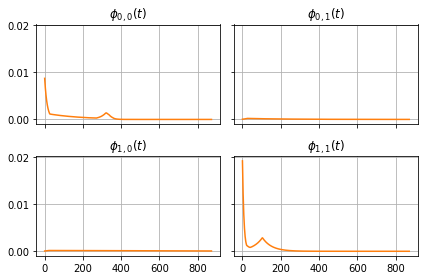

integrated Kernel 1316568.6822856145
796900 2 944679.219523579 944679.219523579 [0.18539649 0.27537604]


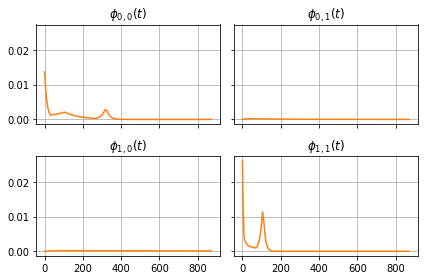

integrated Kernel 1172530.1184227734
796900 3 939525.0252190005 939525.0252190005 [0.18236013 0.26421985]


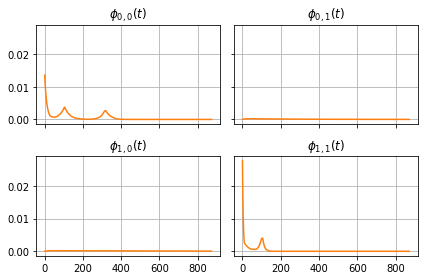

integrated Kernel 1236841.620780785
796900 4 926133.6606226033 926133.6606226033 [0.19254233 0.25604395]


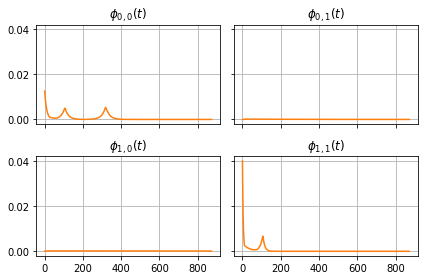

integrated Kernel 1197660.2916871167
796900 5 926133.6606226033 933314.6988124168 [0.1865994  0.27634122]


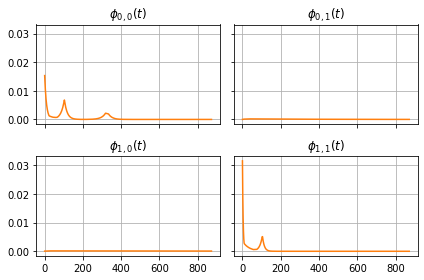

integrated Kernel 1214524.7966168146
796900 6 926133.6606226033 931403.780534667 [0.19731521 0.25728   ]


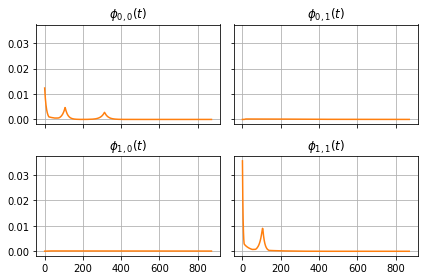

integrated Kernel 1154877.359039024
796900 7 926133.6606226033 932928.4108945589 [0.18349657 0.24430523]


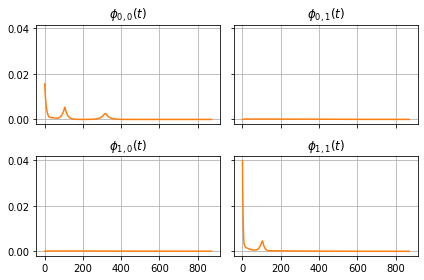

integrated Kernel 1359929.8097926243
796900 8 924713.9990173703 924713.9990173703 [0.19479776 0.23741426]


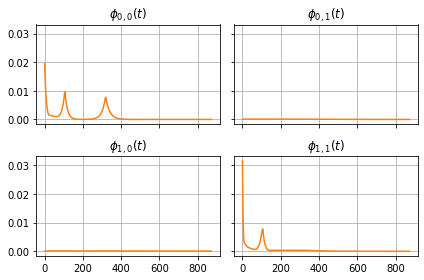

integrated Kernel 1208985.0567421436
796900 9 919000.1655416589 919000.1655416589 [0.19937748 0.21733189]


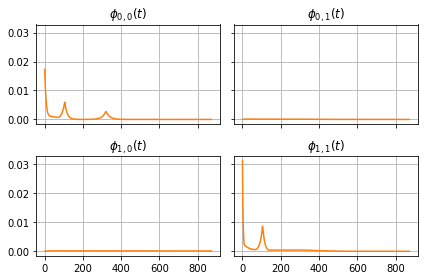

integrated Kernel 1299565.9601582459
796900 10 914819.0276143817 914819.0276143817 [0.19885605 0.26168507]


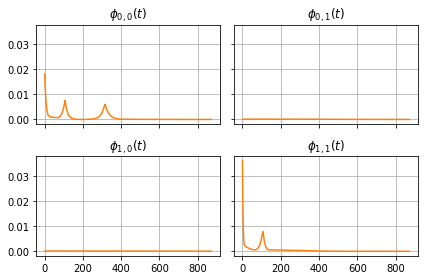

Training scores: [[ 914835.41205625  971716.72255025 1178598.90250806]]
validation Scores [[1828578.54979519 2022295.60610505 2222244.8092047 ]]
TRAIN: [      0       1       2 ... 1593827 1593828 1593829] TEST: [1593830 1593831 1593832 ... 2390741 2390742 2390743]
1593830 number of timepoints
integrated Kernel 2309012.1521697207
1593800 1 1884695.7243800366 1884695.7243800366 [0.18185208 0.20370121]


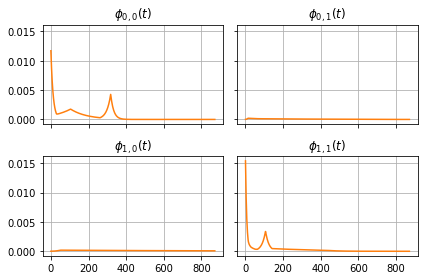

integrated Kernel 2520706.6878813975
1593800 2 1841893.3931210584 1841893.3931210584 [0.17726559 0.20848462]


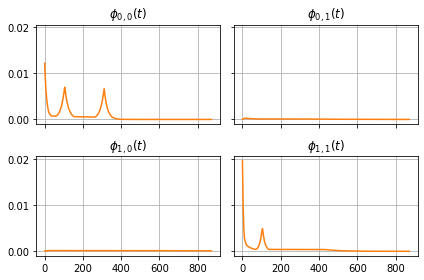

integrated Kernel 2403705.362661568
1593800 3 1841893.3931210584 1854958.842382247 [0.17778836 0.22891278]


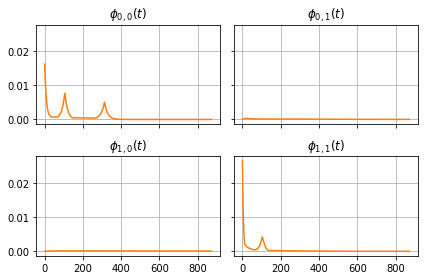

integrated Kernel 2462588.830119534
1593800 4 1839662.2652007074 1839662.2652007074 [0.15704553 0.23024544]


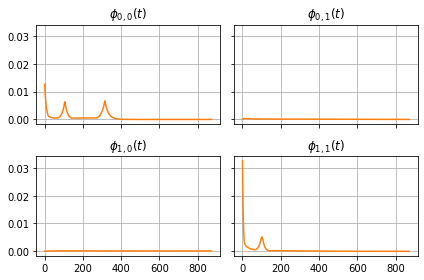

integrated Kernel 2404847.518533148
1593800 5 1839662.2652007074 1845971.6992647252 [0.17830026 0.22710661]


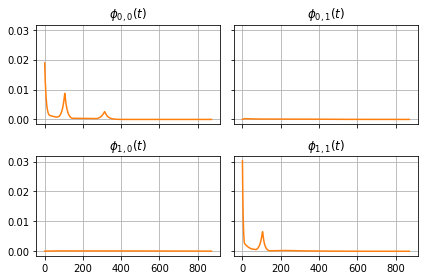

integrated Kernel 2542971.774024087
1593800 6 1821535.2643577417 1821535.2643577417 [0.17250411 0.22908082]


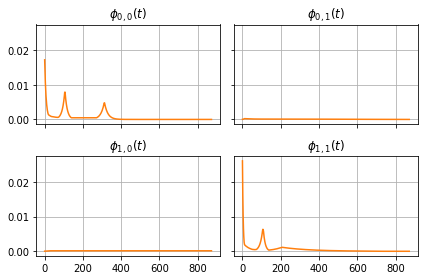

integrated Kernel 2591521.9620682904
1593800 7 1821535.2643577417 1827293.7665592863 [0.17118334 0.21555253]


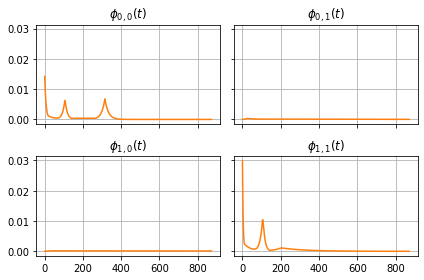

integrated Kernel 2819595.6743174563
1593800 8 1821535.2643577417 1853414.7305505043 [0.16365348 0.22098444]


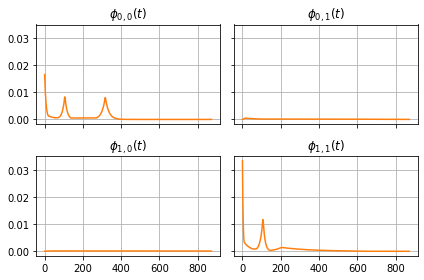

integrated Kernel 2816497.9255302018
1593800 9 1821535.2643577417 1864039.6714187674 [0.17326394 0.22692795]


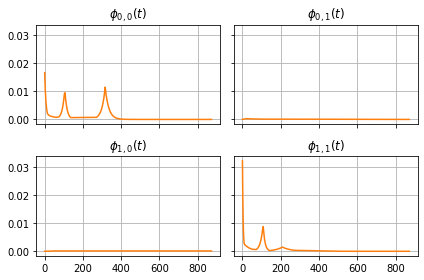

integrated Kernel 2625893.9207443437
1593800 10 1821535.2643577417 1828045.8537875388 [0.17396523 0.22547241]


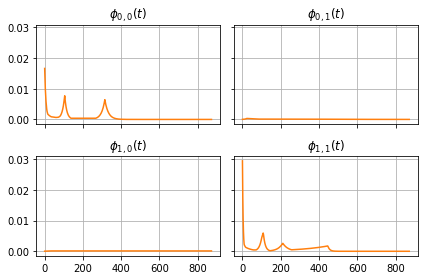

Training scores: [[ 914835.41205625  971716.72255025 1178598.90250806]
 [1821554.08290659 2011707.29230834 2191951.7222845 ]]
validation Scores [[1828578.54979519 2022295.60610505 2222244.8092047 ]
 [2615874.46158528 2874949.41214048 3505822.87302401]]
TRAIN: [      0       1       2 ... 2390741 2390742 2390743] TEST: [2390744 2390745 2390746 ... 3187655 3187656 3187657]
2390744 number of timepoints
integrated Kernel 3525373.3362600477
2390700 1 2691396.7580720396 2691396.7580720396 [0.18924386 0.2388891 ]


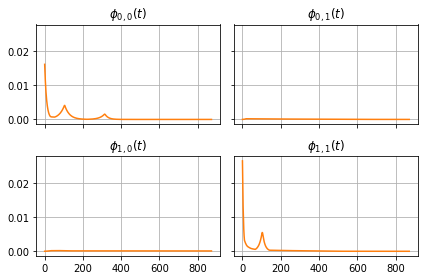

integrated Kernel 3679947.898674773
2390700 2 2634834.773001755 2634834.773001755 [0.20266787 0.21892961]


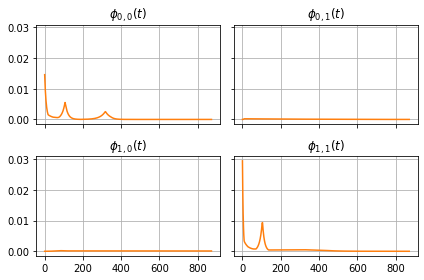

integrated Kernel 3578505.593917409
2390700 3 2634834.773001755 2643169.4310167343 [0.18600105 0.24901934]


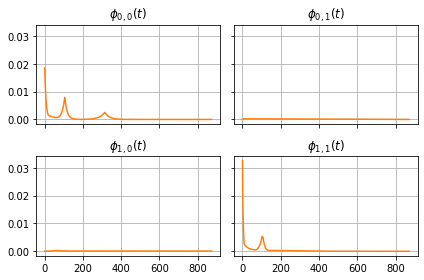

integrated Kernel 3671591.2503086207
2390700 4 2634834.773001755 2639723.1555031477 [0.18215664 0.23071847]


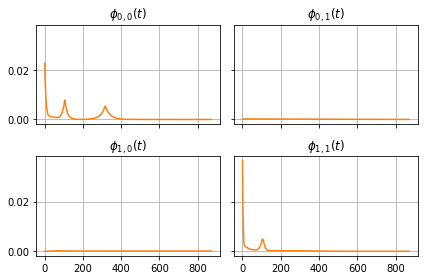

integrated Kernel 3768355.472210939
2390700 5 2631884.044588615 2631884.044588615 [0.1786862  0.22140775]


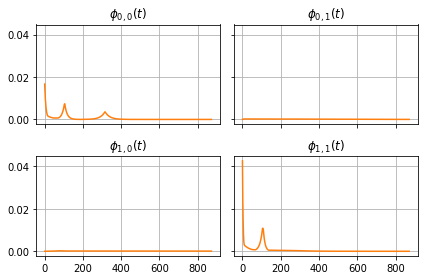

integrated Kernel 3863643.5528258616
2390700 6 2631884.044588615 2634595.0063473457 [0.17592775 0.2507085 ]


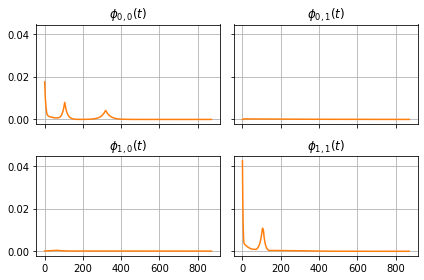

integrated Kernel 3677053.6329032267
2390700 7 2618230.190598685 2618230.190598685 [0.21093159 0.21716767]


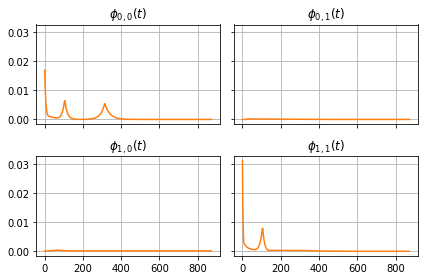

integrated Kernel 3960718.856773765
2390700 8 2618230.190598685 2629922.1412467686 [0.18872166 0.24257514]


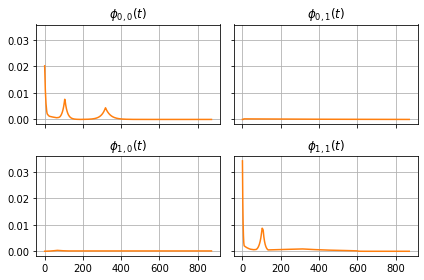

integrated Kernel 3373338.424832393
2390700 9 2618230.190598685 2662172.8098397437 [0.1896075  0.23633144]


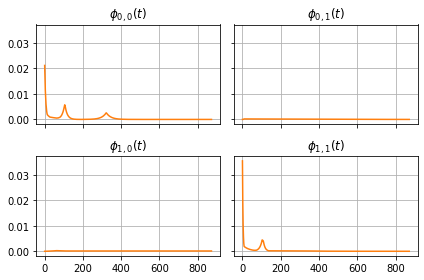

integrated Kernel 3675389.649650589
2390700 10 2618230.190598685 2630324.1983916964 [0.18548372 0.2253733 ]


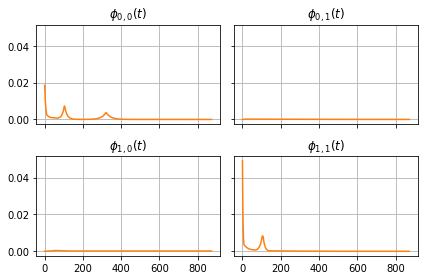

Training scores: [[ 914835.41205625  971716.72255025 1178598.90250806]
 [1821554.08290659 2011707.29230834 2191951.7222845 ]
 [2618274.29009959 2898733.51462639 3545572.0872502 ]]
validation Scores [[1828578.54979519 2022295.60610505 2222244.8092047 ]
 [2615874.46158528 2874949.41214048 3505822.87302401]
 [3726652.38758399 3815103.48324188 4806382.12079214]]
TRAIN: [      0       1       2 ... 3187655 3187656 3187657] TEST: [3187658 3187659 3187660 ... 3984569 3984570 3984571]
3187658 number of timepoints
integrated Kernel 4946078.0623221835
3187650 1 3741664.7978342134 3741664.7978342134 [0.17962917 0.20685529]


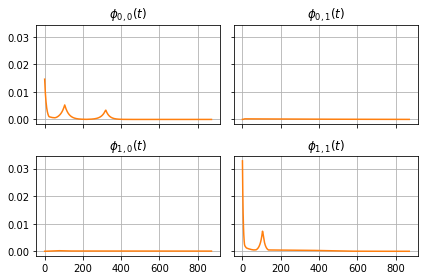

integrated Kernel 5527923.213676933
3187650 2 3741664.7978342134 3749446.4901541527 [0.19186269 0.22170674]


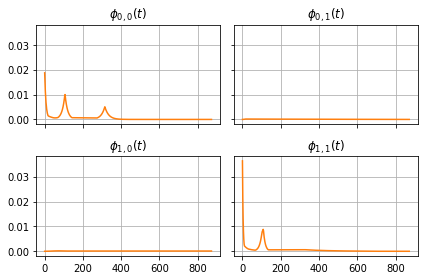

integrated Kernel 5511645.306331345
3187650 3 3741664.7978342134 3887219.99158344 [0.16954775 0.20450577]


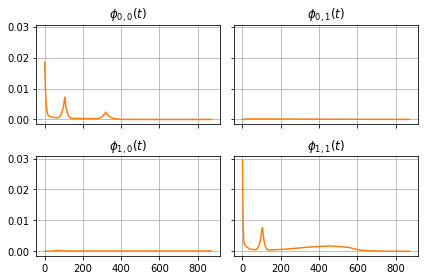

integrated Kernel 5292541.269789204
3187650 4 3741664.7978342134 3796448.078082549 [0.18194624 0.22757278]


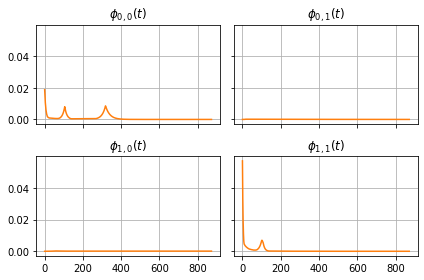

integrated Kernel 4633913.618464232
3187650 5 3741664.7978342134 3798791.4900928177 [0.16751179 0.22003305]


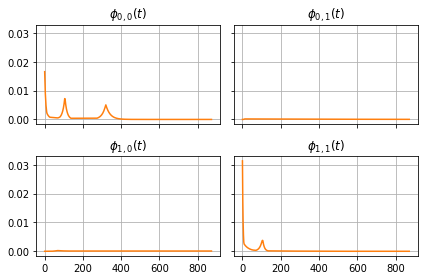

integrated Kernel 5605299.371099547
3187650 6 3741664.7978342134 3779024.3042727686 [0.18156965 0.20467884]
Training scores: [[ 914835.41205625  971716.72255025 1178598.90250806]
 [1821554.08290659 2011707.29230834 2191951.7222845 ]
 [2618274.29009959 2898733.51462639 3545572.0872502 ]
 [3741705.93176177 3802645.3272919  4853898.38815047]]
validation Scores [[1828578.54979519 2022295.60610505 2222244.8092047 ]
 [2615874.46158528 2874949.41214048 3505822.87302401]
 [3726652.38758399 3815103.48324188 4806382.12079214]
 [4348635.64741277 4684683.94788292 5921098.35514087]]
TRAIN: [      0       1       2 ... 3984569 3984570 3984571] TEST: [3984572 3984573 3984574 ... 4781483 4781484 4781485]
3984572 number of timepoints
integrated Kernel 6489427.985001266
3984550 1 4388543.41002407 4388543.41002407 [0.19719068 0.26628418]


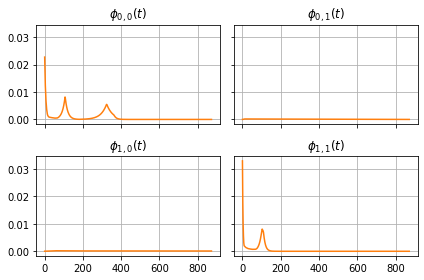

integrated Kernel 6450318.919564403
3984550 2 4319186.069662806 4319186.069662806 [0.21842765 0.23977672]


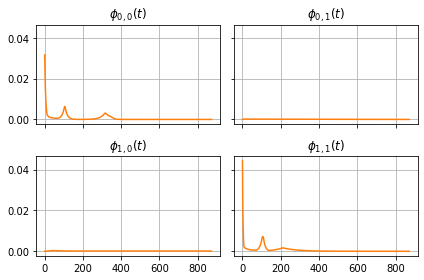

integrated Kernel 5997805.990699956
3984550 3 4319186.069662806 4366674.644268361 [0.20112533 0.24759491]


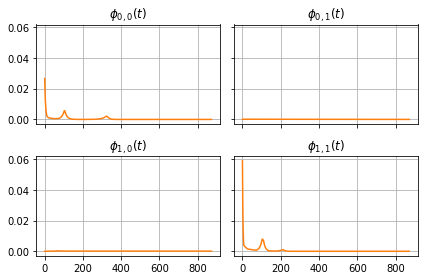

integrated Kernel 6257352.308072906
3984550 4 4311738.874061187 4311738.874061187 [0.20397697 0.24211899]


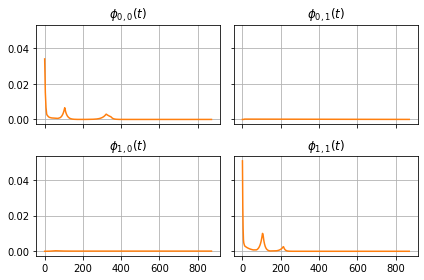

integrated Kernel 5874553.80351747
3984550 5 4311738.874061187 4327079.910472673 [0.19148549 0.23175802]


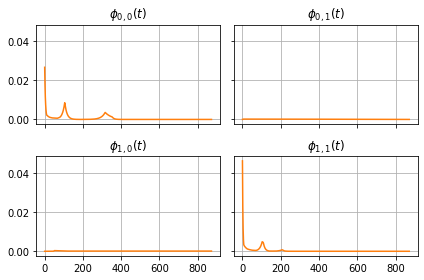

integrated Kernel 6462858.883887518
3984550 6 4278894.461124768 4278894.461124768 [0.20016322 0.23933067]


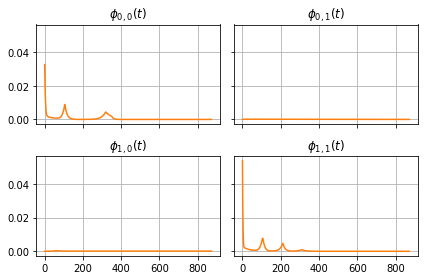

integrated Kernel 6117686.521313577
3984550 7 4278894.461124768 4304530.106103006 [0.21030373 0.23610341]


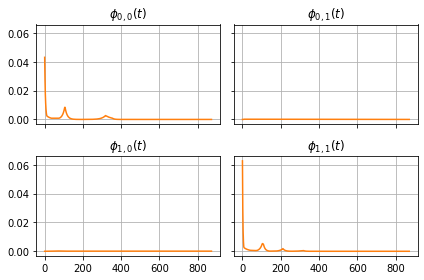

integrated Kernel 6129566.301668766
3984550 8 4278894.461124768 4312271.605542523 [0.21911362 0.23401464]


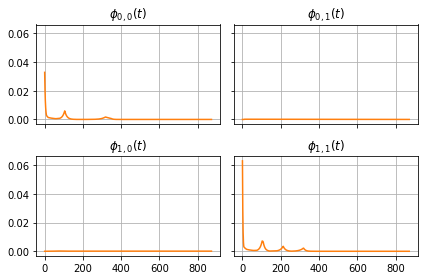

integrated Kernel 6327020.094188921
3984550 9 4278894.461124768 4333103.6139302375 [0.21187818 0.22752039]


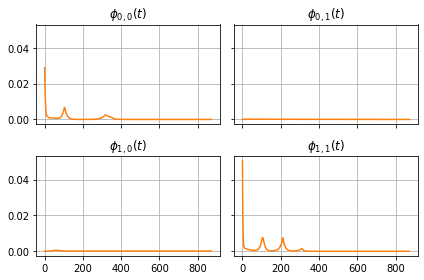

integrated Kernel 5904276.079748212
3984550 10 4278894.461124768 4296081.250952522 [0.18844844 0.25376618]


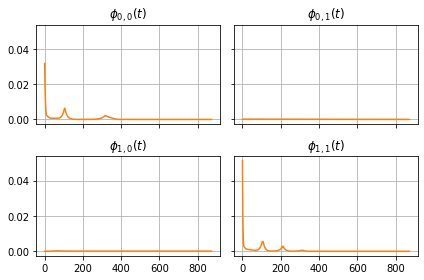

Training scores: [[ 914835.41205625  971716.72255025 1178598.90250806]
 [1821554.08290659 2011707.29230834 2191951.7222845 ]
 [2618274.29009959 2898733.51462639 3545572.0872502 ]
 [3741705.93176177 3802645.3272919  4853898.38815047]
 [4279057.39932288 4663513.58767849 6027381.00362292]]
validation Scores [[1828578.54979519 2022295.60610505 2222244.8092047 ]
 [2615874.46158528 2874949.41214048 3505822.87302401]
 [3726652.38758399 3815103.48324188 4806382.12079214]
 [4348635.64741277 4684683.94788292 5921098.35514087]
 [5155416.60881579 5396887.67375167 7471271.19659129]]


In [10]:
from tick.hawkes import HawkesEM, HawkesConditionalLaw
from sklearn.model_selection import TimeSeriesSplit


em = HawkesEM(kernel_support = 6, kernel_size=100, n_threads=1, verbose=False, tol=1e-3)
wh = HawkesConditionalLaw(n_quad=200)
n_splits=5
t_cv = TimeSeriesSplit(n_splits=n_splits)

score = []
scoreTrain =[]
dimensions=np.arange(0,totalD,1)
for i in range(totalD):
    dictdimP[i]=np.delete(dimensions,i)

for tr_index, ts_index in t_cv.split(sorted_time):
    optimalParams = []
    epsilon = 1e-8
    Dict_inf={}
    Dict_con={}
    Dict_integrate={}
    Dict_gradient={}
    mapping={}

    print("TRAIN:",tr_index, "TEST:", ts_index)
    X_tr, X_val = sorted_time[tr_index], sorted_time[ts_index]
    #train
    t1 = np.ascontiguousarray(X_tr[X_tr[:,1]==0][:,0]) #select only buy values
    t2 = np.ascontiguousarray(X_tr[X_tr[:,1]==1][:,0]) #select only sell values
    t = list([t1,t2])
    for i in range(totalD):
        for j in (dictdimP[i]):
            mapping[i,j]=createMapAtoBIndex(t[i],t[j])
    SGD = sgdNeuralHawkesBiVariate(100,10,0.01,t)
    em.fit(t)
    wh.fit(t)
    scoreTrain.append([SNHll(),EM_Neg_ll(),WH_Neg_ll()])
    print('Training scores:',np.array(scoreTrain))
    
    #test
    X_total = np.concatenate([X_tr, X_val])
    t1 = np.ascontiguousarray(X_total[X_total[:,1]==0][:,0]) #select only buy values
    t2 = np.ascontiguousarray(X_total[X_total[:,1]==1][:,0]) #select only sell values
    t = list([t1,t2])
    for i in range(totalD):
        for j in (dictdimP[i]):
            mapping[i,j]=createMapAtoBIndex(t[i],t[j])
    snh_ll = SNHll()
    em_ll = EM_Neg_ll()
    wh_ll = WH_Neg_ll()
    score.append([snh_ll,em_ll,wh_ll])
    print('validation Scores', np.array(score))


In [26]:
n_splits=len(score)
SNH_score=EM_score=WH_score=0
for j in range(0,n_splits):
    SNH_score+=score[j][0]
    EM_score+=score[j][1]
    WH_score+=score[j][2]
    
print("SNH -",SNH_score/n_splits,"\t EM-",EM_score/n_splits,"\t WH-",WH_score/n_splits)

SNH - 3535031.5310386047 	 EM- 3758784.024624401 	 WH- 4785363.8709506


In [ ]:
#baseline                        
optimalParams = SGD[0]
print('mu_SNH =',optimalParams[4],'mu_EM =', em.baseline,'mu_WH =',wh.baseline)

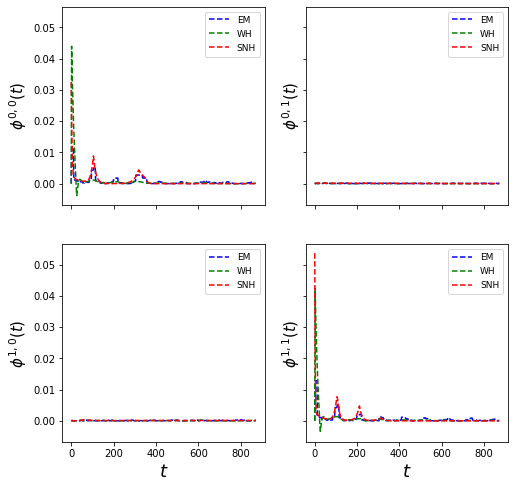

In [44]:
#Kernel plot

#get node
def nnOptimalKernel(x,p,k):
    optimalkernel = SGD[0]
    Alpha0 = optimalkernel[0]
    Alphas = optimalkernel[1]
    Betas = optimalkernel[2]
    Beta0 = optimalkernel[3]
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k]
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    n1 = np.maximum(np.dot(betas,x) + beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    
    y = np.exp(y)
    return y



c_nodes = em.n_nodes

#tk
dx=0.01
tk = np.arange(0,5,dx)
y2 = np.zeros([len(tk),4])


    
#plot
fig, ax_list_list = plt.subplots(c_nodes,c_nodes, sharex=True,
                                         sharey=True,figsize=(8, 8))
    
p = 0

for i, ax_list in enumerate(ax_list_list):
    for j, ax in enumerate(ax_list):
        y_values = em.get_kernel_values(i, j, tk)
        ax.plot(tk*1/fac, y_values*fac,'b--', label="EM")
        y_values = wh.get_kernel_values(i, j, tk)
        ax.plot(tk*1/fac, y_values*fac,'g--', label="WH")
        y_values = (nnOptimalKernel(tk.reshape(1,-1),i,j)).reshape(-1)
        ax.plot(tk*1/fac, y_values*fac,'r--', label="SNH")
        p = p+1
        
        # set x_label for last line
        if i == c_nodes - 1:
            ax.set_xlabel(r"$t$", fontsize=18)

        ax.set_ylabel(r"$\phi^{%g,%g}(t)$" % (i, j), fontsize=15)
        
        legend = ax.legend()
        for label in legend.get_texts():
            label.set_fontsize(9)
#plt.axis([-0.1,2.5, -0.2, 20])

TRAIN: [     0      1      2 ... 796913 796914 796915] TEST: [ 796916  796917  796918 ... 1593827 1593828 1593829]
TRAIN: [      0       1       2 ... 1593827 1593828 1593829] TEST: [1593830 1593831 1593832 ... 2390741 2390742 2390743]
TRAIN: [      0       1       2 ... 2390741 2390742 2390743] TEST: [2390744 2390745 2390746 ... 3187655 3187656 3187657]
TRAIN: [      0       1       2 ... 3187655 3187656 3187657] TEST: [3187658 3187659 3187660 ... 3984569 3984570 3984571]
TRAIN: [      0       1       2 ... 3984569 3984570 3984571] TEST: [3984572 3984573 3984574 ... 4781483 4781484 4781485]
[796916, 1593830, 2390744, 3187658, 3984572] [1593830 2390744 3187658 3984572 4781486]


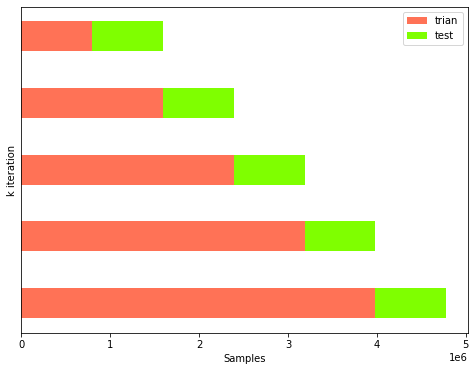

In [60]:

train_n=[]
test_n=[]
for tr_index, ts_index in t_cv.split(sorted_time):

    print("TRAIN:",tr_index, "TEST:", ts_index)
    train_n.append(len(tr_index))
    test_n.append(len(ts_index))
print(train_n,np.array(train_n)+np.array(test_n))
N=len(train_n)
ind = np.arange(N)  
width = 0.45 
 
fig = plt.subplots(figsize =(8, 6))
p1 = plt.barh(ind, train_n[::-1], width, color ='#FF7256')
p2 = plt.barh(ind, test_n[::-1], width,
             left = train_n[::-1], color ='#7FFF00')
 
plt.ylabel('k iteration')
plt.xlabel('Samples')

plt.yticks([])
plt.xticks(np.arange(0,5100000,1000000))
plt.legend((p1[0], p2[0]), ('trian', 'test'))

plt.savefig("barplot Iteration",dpi=200)

